In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import operator
# Non pythonic hack to reuse some utility code
if sys.path[0] != '../../py_utils':
    sys.path.insert(0,'../../py_utils')

import file_utils  
import utils
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from pathlib import Path
%matplotlib inline
pd.set_option('display.max_columns', 500)
print("Seaborn version: ", sns.__version__)

C:\Users\CHIPK\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Seaborn version:  0.9.0


In [2]:
summary_team_file = '../../Data/sr_summaries_kaggle_id_no_opp_2018.csv'
team_meta_data_file = '../../Data/D1_teams.csv'
tournament_data_file = '../../Data/tournament_results_2018.csv'
rankings_data_file = '../../data/massey_seasons_with_id.csv'

feature_dictionary = utils.Feature_Dictionary()

In [3]:
# Do not use 2018 data for training
start_tournament = 2003
stop_tournament = 2017

#### Read in regular season team statistics from SRCBB https://www.sports-reference.com/cbb/

#### Read table of team names and associated team meta data from the Kaggle data set.
https://console.cloud.google.com/bigquery?project=bigqueryncaa&p=bigquery-public-data&d=ncaa_basketball&page=dataset

In [4]:
summary_data = file_utils.read_summary_team_data(summary_team_file)
teams = file_utils.read_team_meta_data(team_meta_data_file)
summary_data.head()

,season,school,team_id,games,srs,sos,win_pct,pts_avg,opp_pts_avg,fg_pct,ft_pct,poss_avg,off_rebs_avg,def_rebs_avg,to_avg,steal_avg,off_rating,ft_att_avg
0,2000,Air Force,aa7af640-5762-4686-9181-39f7b8a8186e,29,-3.57,1.99,0.276,57,63,0.435,0.697,63.020690,6.0,16.0,13,7,90.446487,16
1,2000,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,28,-3.09,1.67,0.429,67,72,0.452,0.725,73.857143,9.0,20.0,15,5,90.715667,23
2,2000,Alabama,c2104cdc-c83d-40d2-a3cd-df986e29f5d3,36,14.02,6.27,0.694,76,68,0.433,0.698,86.200000,16.0,26.0,15,7,88.167053,24
3,2000,Alabama A&M,949c3398-85e4-4c63-ba71-9a82e06ddea4,28,-13.46,-11.79,0.607,73,74,0.391,0.626,94.264286,17.0,22.0,16,12,77.441843,23
4,2000,Alabama State,267d417a-8f85-4c87-a15a-068c089a74c6,31,-8.86,-13.61,0.710,68,63,0.441,0.658,80.690323,12.0,25.0,16,8,84.272807,22


#### Read in the NCAA Men's Tournament results from the the Kaggle data set.

In [5]:
tourney_data = file_utils.read_tournament_results(tournament_data_file,start_tournament)
game_data = utils.compute_game_data(tourney_data, teams)
computer_rankings = pd.read_csv(Path(rankings_data_file))
computer_rankings = computer_rankings[computer_rankings['season'] >= start_tournament]

tourney_data = utils.recode_tourney_data(tourney_data)
tourney_data = file_utils.merge_tourney_summary_data(tourney_data, summary_data)
tourney_data = file_utils.join_tourney_team_data(tourney_data, teams)
tourney_comp_ratings = file_utils.merge_tourney_ranking_data(tourney_data, computer_rankings)
tourney_comp_ratings = utils.implement_top_conference_feature(tourney_data, teams, game_data, tourney_comp_ratings)
tourney_comp_ratings = utils.implement_seed_threshold_feature(tourney_comp_ratings)
tourney_comp_ratings = utils.compute_delta_features(tourney_comp_ratings)

tourney_comp_ratings.dropna(inplace=True)
tourney_comp_ratings[tourney_comp_ratings.isnull().any(axis=1)]


,season_t,round,game_date,seed_t,team_t,team_id_t,win_pts,seed_o,team_o,team_id_o,lose_pts,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf_t,top_conf_o,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor


In [6]:
numeric_features = ['delta_margin_victory_avg', 'delta_fg_pct', 'delta_off_rebs_avg',
                            'delta_def_rebs_avg', 'delta_ft_pct',
                            'delta_to_net_avg', 'delta_win_pct', 'delta_off_rating',
                            'delta_ft_att_avg',
                            'delta_seed', 'delta_srs', 'delta_sos',
                            'delta_sag', 'delta_wlk', 'delta_wol',
                            'delta_rth', 'delta_col', 'delta_pom',
                            'delta_dol', 'delta_rpi', 'delta_mor']

for item in numeric_features:
    tourney_comp_ratings[item] = tourney_comp_ratings[item].astype(float)

#scaler =StandardScaler()
#tourney_comp_ratings[numeric_feature_to_scale] = scaler.fit_transform(tourney_comp_ratings[numeric_feature_to_scale])
#tourney_comp_ratings.head()

In [7]:
feature_columns = numeric_features  + ['season_t', 'top_conf_t', 'top_conf_o']

In [8]:
feature_data = tourney_comp_ratings[feature_columns].copy()
#feature_data

#### Setup feature columns for Tensorflow

In [9]:
tf_top_conf_t = tf.feature_column.numeric_column('top_conf_t')
tf_top_conf_o = tf.feature_column.numeric_column('top_conf_o')
tf_margin_victory = tf.feature_column.numeric_column('delta_margin_victory_avg')
tf_delta_fg = tf.feature_column.numeric_column('delta_fg_pct')
tf_delta_off_rebs = tf.feature_column.numeric_column('delta_off_rebs_avg')
tf_delta_def_rebs = tf.feature_column.numeric_column('delta_def_rebs_avg')
tf_delta_ft = tf.feature_column.numeric_column('delta_ft_pct')
tf_delta_to = tf.feature_column.numeric_column('delta_to_net_avg')
tf_delta_win = tf.feature_column.numeric_column('delta_win_pct')
tf_delta_off_rating = tf.feature_column.numeric_column('delta_off_rating')
tf_delta_ft_att = tf.feature_column.numeric_column('delta_ft_att_avg')
tf_delta_seed = tf.feature_column.numeric_column('delta_seed')
tf_delta_srs = tf.feature_column.numeric_column('delta_srs')
tf_delta_sos = tf.feature_column.numeric_column('delta_sos')
tf_delta_sag = tf.feature_column.numeric_column('delta_sag')
tf_delta_wlk = tf.feature_column.numeric_column('delta_wlk')
tf_delta_wol = tf.feature_column.numeric_column('delta_wol')
tf_delta_rth = tf.feature_column.numeric_column('delta_rth')
tf_delta_col = tf.feature_column.numeric_column('delta_col')
tf_delta_pom = tf.feature_column.numeric_column('delta_pom')
tf_delta_dol = tf.feature_column.numeric_column('delta_dol')
tf_delta_rpi = tf.feature_column.numeric_column('delta_rpi')
tf_delta_mor = tf.feature_column.numeric_column('delta_mor')

tf_feat_cols = [tf_margin_victory, tf_delta_fg, tf_delta_off_rebs, 
                tf_delta_def_rebs, tf_delta_ft, tf_delta_to, tf_delta_win, tf_delta_off_rating, 
                tf_delta_ft_att, tf_delta_seed, tf_delta_srs, tf_delta_sos, tf_delta_sag, 
                tf_delta_wlk, tf_delta_wol, tf_delta_rth, tf_delta_col, tf_delta_pom,
                tf_delta_dol, tf_delta_rpi, tf_delta_mor]

In [10]:
X= feature_data[feature_data['season_t']<= stop_tournament]
tourney_comp_ratings['label'] = tourney_comp_ratings.apply(lambda x: 0 if x.game_result==-1 else 1, axis=1)
y=tourney_comp_ratings[tourney_comp_ratings['season_t']<= stop_tournament]['label']
X= X.drop(columns=['season_t'])

feature_list = list(X)
feature_list

['delta_margin_victory_avg',
 'delta_fg_pct',
 'delta_off_rebs_avg',
 'delta_def_rebs_avg',
 'delta_ft_pct',
 'delta_to_net_avg',
 'delta_win_pct',
 'delta_off_rating',
 'delta_ft_att_avg',
 'delta_seed',
 'delta_srs',
 'delta_sos',
 'delta_sag',
 'delta_wlk',
 'delta_wol',
 'delta_rth',
 'delta_col',
 'delta_pom',
 'delta_dol',
 'delta_rpi',
 'delta_mor',
 'top_conf_t',
 'top_conf_o']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 5)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
X_train.head()

(782, 23)
(782,)
(196, 23)
(196,)


,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor,top_conf_t,top_conf_o
784,-3.0,-0.015,0.0,-1.0,0.062,2.0,-0.055,-3.232509,-1.0,3.0,-10.13,-6.65,97.0,106.0,98.0,94.0,88.0,80.0,103.0,81.0,102.0,0,1
125,8.0,0.011,-2.0,0.0,-0.039,-1.0,0.262,8.822234,-1.0,-7.0,5.32,-3.24,-24.0,-33.0,-25.0,-25.0,-28.0,-24.0,-30.0,-27.0,-19.0,0,1
236,3.0,0.022,-4.0,-3.0,0.071,-3.0,0.139,12.896390,4.0,-3.0,4.23,0.00,-11.0,-11.0,-15.0,-13.0,-14.0,-12.0,-18.0,-12.0,-14.0,0,0
719,0.0,-0.010,0.0,-2.0,-0.016,1.0,0.043,-2.544287,-4.0,0.0,-1.24,0.41,8.0,1.0,3.0,2.0,-4.0,-16.0,12.0,-14.0,-7.0,0,0
808,0.0,-0.046,5.0,2.0,-0.051,4.0,-0.008,-7.831221,1.0,-11.0,12.38,11.36,-64.0,-66.0,-58.0,-98.0,-79.0,-56.0,-78.0,-43.0,-73.0,1,0


In [12]:
scaler =StandardScaler(copy=False)

scaler.fit_transform(X_train[numeric_features])
scaler.fit_transform(X_test[numeric_features])

array([[-0.08489588, -0.11551193, -1.87207263, ..., -0.04611168,
         0.14234004, -0.08359018],
       [-1.08327148,  0.78876197,  0.37212453, ...,  0.42251962,
         0.21930183,  0.13522352],
       [ 0.24789598,  0.0519462 , -0.37594119, ..., -0.29716416,
        -0.68499919, -0.16564532],
       ...,
       [ 0.58068785, -0.68486958, -0.00190833, ...,  0.02083565,
        -0.16550711,  0.02581667],
       [ 0.41429191,  0.58781221, -0.37594119, ..., -0.09632218,
         0.02689736, -0.19299704],
       [ 1.07987564,  0.52082896, -0.37594119, ..., -0.63190081,
        -0.78120143, -0.26137632]])

#### Baseline Model

In [13]:
input_func = tf.estimator.inputs.pandas_input_fn(x=X_train, y=y_train, batch_size=50, num_epochs=None, shuffle=True )

In [14]:
model = tf.estimator.LinearClassifier(feature_columns= tf_feat_cols, n_classes=2)
model.train(input_fn = input_func, steps=15000)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\CHIPK\\AppData\\Local\\Temp\\tmpd3qkjpnz', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002798B3D7DD8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for up

INFO:tensorflow:loss = 22.97536, step = 5901 (0.234 sec)
INFO:tensorflow:global_step/sec: 432.188
INFO:tensorflow:loss = 17.801172, step = 6001 (0.231 sec)
INFO:tensorflow:global_step/sec: 424.815
INFO:tensorflow:loss = 18.711245, step = 6101 (0.237 sec)
INFO:tensorflow:global_step/sec: 421.334
INFO:tensorflow:loss = 21.86269, step = 6201 (0.235 sec)
INFO:tensorflow:global_step/sec: 424.864
INFO:tensorflow:loss = 16.275528, step = 6301 (0.236 sec)
INFO:tensorflow:global_step/sec: 416.048
INFO:tensorflow:loss = 11.2666, step = 6401 (0.239 sec)
INFO:tensorflow:global_step/sec: 423.068
INFO:tensorflow:loss = 21.585018, step = 6501 (0.237 sec)
INFO:tensorflow:global_step/sec: 423.07
INFO:tensorflow:loss = 20.320017, step = 6601 (0.236 sec)
INFO:tensorflow:global_step/sec: 423.018
INFO:tensorflow:loss = 19.201674, step = 6701 (0.237 sec)
INFO:tensorflow:global_step/sec: 419.577
INFO:tensorflow:loss = 18.912676, step = 6801 (0.237 sec)
INFO:tensorflow:global_step/sec: 435.946
INFO:tensorflow

INFO:tensorflow:loss = 20.517582, step = 14201 (0.239 sec)
INFO:tensorflow:global_step/sec: 419.453
INFO:tensorflow:loss = 15.130872, step = 14301 (0.239 sec)
INFO:tensorflow:global_step/sec: 416.121
INFO:tensorflow:loss = 16.28397, step = 14401 (0.238 sec)
INFO:tensorflow:global_step/sec: 430.332
INFO:tensorflow:loss = 20.464638, step = 14501 (0.234 sec)
INFO:tensorflow:global_step/sec: 417.777
INFO:tensorflow:loss = 20.135862, step = 14601 (0.237 sec)
INFO:tensorflow:global_step/sec: 419.531
INFO:tensorflow:loss = 18.315374, step = 14701 (0.239 sec)
INFO:tensorflow:global_step/sec: 405.94
INFO:tensorflow:loss = 19.723408, step = 14801 (0.247 sec)
INFO:tensorflow:global_step/sec: 421.289
INFO:tensorflow:loss = 19.3725, step = 14901 (0.237 sec)
INFO:tensorflow:Saving checkpoints for 15000 into C:\Users\CHIPK\AppData\Local\Temp\tmpd3qkjpnz\model.ckpt.
INFO:tensorflow:Loss for final step: 14.748561.


In [15]:
eval_input_func = tf.estimator.inputs.pandas_input_fn(x=X_test, y=y_test, batch_size=50, num_epochs=1, shuffle=False)

In [16]:
results = model.evaluate(eval_input_func)
results

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-02-02-04:08:52
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\CHIPK\AppData\Local\Temp\tmpd3qkjpnz\model.ckpt-15000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-02-02-04:08:53
INFO:tensorflow:Saving dict for global step 15000: accuracy = 0.7397959, accuracy_baseline = 0.54591835, auc = 0.8397039, auc_precision_recall = 0.8525922, average_loss = 0.51146084, global_step = 15000, label/mean = 0.54591835, loss = 25.06158, precision = 0.7692308, prediction/mean = 0.54717034, recall = 0.74766356
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 15000: C:\Users\CHIPK\AppData\Local\Temp\tmpd3qkjpnz\model.ckpt-15000


{'accuracy': 0.7397959,
 'accuracy_baseline': 0.54591835,
 'auc': 0.8397039,
 'auc_precision_recall': 0.8525922,
 'average_loss': 0.51146084,
 'label/mean': 0.54591835,
 'loss': 25.06158,
 'precision': 0.7692308,
 'prediction/mean': 0.54717034,
 'recall': 0.74766356,
 'global_step': 15000}

#### Identify the predicted results for the test samples

In [17]:
pred_input_func = tf.estimator.inputs.pandas_input_fn(x=X_test, batch_size=50, num_epochs=1, shuffle=False)
predictions_test = model.predict(pred_input_func)
test_predictions = list(predictions_test)
test_predictions

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\CHIPK\AppData\Local\Temp\tmpd3qkjpnz\model.ckpt-15000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


[{'logits': array([1.5583034], dtype=float32),
  'logistic': array([0.82610977], dtype=float32),
  'probabilities': array([0.17389025, 0.82610977], dtype=float32),
  'class_ids': array([1], dtype=int64),
  'classes': array([b'1'], dtype=object)},
 {'logits': array([0.99670404], dtype=float32),
  'logistic': array([0.7304101], dtype=float32),
  'probabilities': array([0.26958996, 0.7304101 ], dtype=float32),
  'class_ids': array([1], dtype=int64),
  'classes': array([b'1'], dtype=object)},
 {'logits': array([2.7883313], dtype=float32),
  'logistic': array([0.942042], dtype=float32),
  'probabilities': array([0.057958, 0.942042], dtype=float32),
  'class_ids': array([1], dtype=int64),
  'classes': array([b'1'], dtype=object)},
 {'logits': array([1.5581442], dtype=float32),
  'logistic': array([0.8260869], dtype=float32),
  'probabilities': array([0.1739131, 0.8260869], dtype=float32),
  'class_ids': array([1], dtype=int64),
  'classes': array([b'1'], dtype=object)},
 {'logits': array([-1

In [18]:
test_preds = [pred['class_ids'][0] for pred in test_predictions ]

In [19]:
y_test_df = y_test.to_frame('y_actual')
y_test_df['y_predict'] = test_preds


In [20]:
missed_predictions = y_test_df[y_test_df['y_actual'] != y_test_df['y_predict']].copy()
missed_predictions.reset_index(inplace=True)
missed_predictions.rename({"index":"sample_index"}, axis='columns', inplace=True)
missed_predictions = missed_predictions.sort_values(by=['sample_index'])
len(missed_predictions.index)

51

array([[65, 24],
       [27, 80]], dtype=int64)

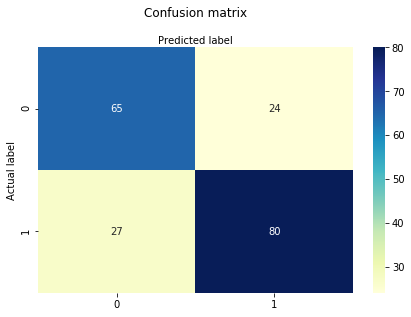

In [21]:
utils.display_confusion_matrix(y_test, test_preds)

#### Predict 2018

In [22]:
test_year = 2018
X_season = feature_data[feature_data['season_t']== test_year]
scaler.fit_transform(X_season[numeric_features])
y_season = tourney_comp_ratings[tourney_comp_ratings['season_t']== test_year]['label']
X_season.shape

(67, 24)

In [23]:
pred_2018_input_func = tf.estimator.inputs.pandas_input_fn(x=X_season, batch_size=10, num_epochs=1, shuffle=False)
predictions_2018 = model.predict(pred_2018_input_func)
pred_2018 = list(predictions_2018)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\CHIPK\AppData\Local\Temp\tmpd3qkjpnz\model.ckpt-15000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [24]:
preds_2018 = [pred['class_ids'][0] for pred in pred_2018 ]
y_2018_df = y_season.to_frame('y_actual')
y_2018_df['y_predict'] = preds_2018
y_2018_df.head()

,y_actual,y_predict
981,1,1
982,0,0
983,1,1
984,0,0
985,1,0


In [25]:
t1_win_probabilities = [pred['probabilities'][1] for pred in pred_2018 ]
#t1_win_probabilities

[0.94204134,
 0.30922452,
 0.9281424,
 0.13660865,
 0.0015042931,
 0.047357596,
 0.991836,
 0.754494,
 0.92350847,
 0.26386642,
 0.6039707,
 0.33244306,
 0.9966499,
 0.0039543365,
 0.98848164,
 0.03756673,
 0.9527245,
 0.29131457,
 0.62306833,
 0.15594353,
 0.999619,
 0.00218425,
 0.9902361,
 0.7997888,
 0.9689159,
 0.27340022,
 0.67209363,
 0.475818,
 0.99742955,
 0.004093795,
 0.9874105,
 0.056006152,
 0.91025186,
 0.32185712,
 0.50816786,
 0.20255943,
 0.8992534,
 0.53394413,
 0.26748052,
 0.08258971,
 0.31277773,
 0.8603145,
 0.93284225,
 0.66988426,
 0.9982942,
 0.16000769,
 0.7111683,
 0.035010375,
 0.9510757,
 0.058486197,
 0.17016181,
 0.4323484,
 0.26811424,
 0.49303806,
 0.68322355,
 0.085803494,
 0.98543733,
 0.80062234,
 0.93623483,
 0.09633001,
 0.57618433,
 0.19694778,
 0.98754054,
 0.37340018,
 0.8877289,
 0.09660264,
 0.9598297]

In [26]:
missed_2018_predictions = y_2018_df[y_2018_df['y_actual'] != y_2018_df['y_predict']].copy()

missed_2018_predictions.reset_index(inplace=True)
missed_2018_predictions.rename({"index":"sample_index"}, axis='columns', inplace=True)
missed_2018_predictions = missed_2018_predictions.sort_values(by=['sample_index'])
#len(missed_2018_predictions.index)
missed_2018_predictions

,sample_index,y_actual,y_predict
0,985,1,0
1,988,0,1
2,1004,0,1
3,1018,0,1
4,1019,1,0
5,1021,1,0
6,1022,0,1
7,1024,0,1
8,1031,1,0
9,1033,1,0


array([[27,  6],
       [ 5, 29]], dtype=int64)

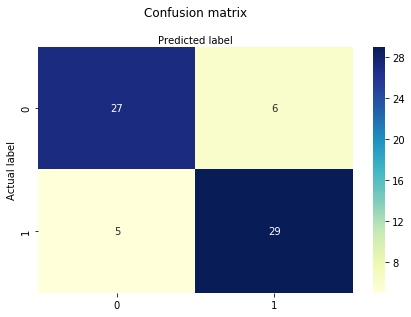

In [27]:
utils.display_confusion_matrix(y_season, preds_2018)

#### Counter Seeding Predictions

In [36]:
def map_zero_to_minus_one(x):
    if x==0:
        return -1
    else:
        return x
    

In [29]:
tourney_games = tourney_comp_ratings[tourney_comp_ratings.index.isin(X_season.index)].copy()
tourney_games['predicted'] = preds_2018
tourney_games.predicted = tourney_games['predicted'].apply(lambda x: map_zero_to_minus_one(x))
tourney_games.head()

,season_t,round,game_date,seed_t,team_t,team_id_t,win_pts,seed_o,team_o,team_id_o,lose_pts,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf_t,top_conf_o,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor,label,predicted
981,2018,68,2018-03-01 00:00:00.0000000,16,Radford,f2cf9ba2-ac8c-4d92-8e7a-48dd88e8f40b,71,16,Long Island University,82c12e8d-7c6c-47d8-b100-3cbc190d268e,61,1,2017,Win,-2.61,-4.08,0.639,67.0,64.0,0.425,0.725,74.627778,11.0,23.0,12.0,6.0,89.778903,17.0,-8.61,-8.19,0.514,77.0,76.0,0.455,0.696,81.868571,10.0,27.0,14.0,5.0,94.053186,22.0,Big South,Northeast,191,170.0,149,184,160.0,170.0,158.0,128.0,165,256,242.0,234,266,239.0,252.0,243.0,232.0,205,0,0,0,3.0,1.0,2.0,-0.030,1.0,-4.0,0.029,6.0,9.0,-3.0,0.125,-4.274284,-5.0,0.0,6.00,4.11,-65.0,-72.0,-85.0,-82.0,-79.0,-82.0,-85.0,-104.0,-40.0,1,1
982,2018,68,2018-03-01 00:00:00.0000000,11,UCLA,ec0d6b67-4b16-4b50-92b2-1a651dae6b0f,65,11,St. Bonaventure,22d90601-19d4-461b-a901-924d12f116ed,58,-1,2017,Lose,12.07,6.86,0.636,81.0,75.0,0.460,0.720,81.787879,10.0,28.0,12.0,5.0,99.036680,21.0,8.87,2.61,0.765,77.0,70.0,0.451,0.752,78.458824,10.0,25.0,11.0,7.0,98.140651,23.0,Pacific 12,Atlantic 10,44,44.0,49,46,35.0,48.0,51.0,36.0,54,60,59.0,33,62,32.0,69.0,44.0,24.0,60,1,0,0,6.0,7.0,-1.0,0.009,0.0,3.0,-0.032,7.0,4.0,3.0,-0.129,0.896029,-2.0,0.0,3.20,4.25,-16.0,-15.0,16.0,-16.0,3.0,-21.0,7.0,12.0,-6.0,0,-1
983,2018,68,2018-03-01 00:00:00.0000000,16,Texas Southern,eb157f98-0697-459c-9293-ddb162ceb28b,64,16,North Carolina Central,e4c315a0-e83f-4d14-856e-34a0463059e3,46,1,2017,Win,-7.53,-5.53,0.444,77.0,79.0,0.438,0.725,81.288889,10.0,25.0,12.0,5.0,94.723893,25.0,-13.19,-12.31,0.543,72.0,69.0,0.461,0.687,79.822857,11.0,26.0,14.0,5.0,90.199728,17.0,Southwestern Athletic,Mid Eastern Athletic,242,240.0,265,296,249.0,249.0,276.0,222.0,256,295,296.0,280,313,278.0,309.0,293.0,279.0,310,0,0,0,-2.0,3.0,-5.0,-0.023,-1.0,-1.0,0.038,7.0,9.0,-2.0,-0.099,4.524165,8.0,0.0,5.66,6.78,-53.0,-56.0,-15.0,-17.0,-29.0,-60.0,-17.0,-57.0,-54.0,1,1
984,2018,68,2018-03-01 00:00:00.0000000,11,Arizona State,ad4bc983-8d2e-4e6f-a8f9-80840a786c64,60,11,Syracuse,8cd24de1-2be8-4b77-bcfa-47be0495a5f4,56,-1,2017,Lose,14.37,6.56,0.625,82.0,74.0,0.463,0.733,80.631250,9.0,25.0,10.0,6.0,101.697543,24.0,12.89,10.02,0.622,66.0,63.0,0.417,0.736,75.075676,11.0,25.0,12.0,6.0,87.911297,21.0,Pacific 12,Atlantic Coast,49,43.0,60,45,41.0,45.0,60.0,66.0,52,50,50.0,58,49,44.0,54.0,53.0,45.0,44,0,0,0,8.0,3.0,5.0,0.046,-2.0,0.0,-0.003,4.0,6.0,-2.0,0.003,13.786246,3.0,0.0,1.48,-3.46,-1.0,-7.0,2.0,-4.0,-3.0,-9.0,7.0,21.0,8.0,0,-1
985,2018,64,2018-03-01 00:00:00.0000000,16,UMBC,32755362-6336-4dd3-ac34-6f72a6cc150b,74,1,Virginia,56913910-87f7-4ad7-ae3b-5cd9fb218fd9,54,1,2017,Win,-2.02,-3.84,0.694,73.0,68.0,0.443,0.646,77.344444,9.0,24.0,12.0,7.0,94.382991,17.0,22.21,9.07,0.912,67.0,54.0,0.460,0.754,68.070588,8.0,24.0,8.0,6.0,98.427238,13.0,America East,Atlantic Coast,189,168.0,125,176,140.0,184.0,123.0,111.0,155,2,2.0,1,1,1.0,1.0,1.0,1.0,1,0,1,1,5.0,13.0,-8.0,-0.017,1.0,0.0,-0.108,5.0,2.0,3.0,-0.218,-4.044247,4.0,15.0,-24.23,-12.91,187.0,166.0,124.0,175.0,139.0,183.0,122.0,110.0,154.0,1,-1


In [30]:
cond_1 = (tourney_games['seed_t'] > tourney_games['seed_o']) & (tourney_games['predicted'] == 1)
cond_2 = (tourney_games['seed_t'] < tourney_games['seed_o']) & (tourney_games['predicted'] == -1)

predictions_counter_seed = tourney_games[cond_1 | cond_2]
predictions_counter_seed[['round','seed_t','team_t','seed_o','team_o','game_result','predicted','win_pts','lose_pts']]

,round,seed_t,team_t,seed_o,team_o,game_result,predicted,win_pts,lose_pts
990,64,6,Miami,11,Loyola Chicago,-1,-1,64,62
992,64,8,Creighton,9,Kansas St,-1,-1,69,59
1000,64,8,Missouri,9,Florida St,-1,-1,67,54
1007,64,10,Butler,7,Arkansas,1,1,79,62
1008,64,8,Virginia Tech,9,Alabama,-1,-1,86,83
1014,64,6,TCU,11,Syracuse,-1,-1,57,52
1024,32,5,Ohio St,4,Gonzaga,-1,1,90,84
1032,32,4,Auburn,5,Clemson,-1,-1,84,53
1034,16,7,Nevada,11,Loyola Chicago,-1,-1,69,68
1035,16,9,Florida St,4,Gonzaga,1,1,75,60


In [31]:
# correct counter seed predictions
correct_counter_predictions = predictions_counter_seed[predictions_counter_seed['game_result']== predictions_counter_seed['predicted']]
correct_counter_predictions[['round','seed_t','team_t','seed_o','team_o','game_result','predicted','win_pts','lose_pts']]

,round,seed_t,team_t,seed_o,team_o,game_result,predicted,win_pts,lose_pts
990,64,6,Miami,11,Loyola Chicago,-1,-1,64,62
992,64,8,Creighton,9,Kansas St,-1,-1,69,59
1000,64,8,Missouri,9,Florida St,-1,-1,67,54
1007,64,10,Butler,7,Arkansas,1,1,79,62
1008,64,8,Virginia Tech,9,Alabama,-1,-1,86,83
1014,64,6,TCU,11,Syracuse,-1,-1,57,52
1032,32,4,Auburn,5,Clemson,-1,-1,84,53
1034,16,7,Nevada,11,Loyola Chicago,-1,-1,69,68
1035,16,9,Florida St,4,Gonzaga,1,1,75,60
1041,8,11,Loyola Chicago,9,Kansas St,1,1,78,62


In [32]:
# incorrect counter seed predictions
wrong_counter_predictions = predictions_counter_seed[predictions_counter_seed['game_result'] != predictions_counter_seed['predicted']]
wrong_counter_predictions[['round','seed_t','team_t','seed_o','team_o','game_result','predicted','win_pts','lose_pts']]

,round,seed_t,team_t,seed_o,team_o,game_result,predicted,win_pts,lose_pts
1024,32,5,Ohio St,4,Gonzaga,-1,1,90,84


In [33]:
print("Number of counter seed predictions= ", len(predictions_counter_seed.index))
print("Number of correct counter seed predictions= ", len(correct_counter_predictions.index))

Number of counter seed predictions=  11
Number of correct counter seed predictions=  10


In [41]:
log_loss_result = utils.compute_log_loss(tourney_games['game_result'].values, np.array(t1_win_probabilities))
log_loss_result

0.4601871225202748